In [8]:
import pandas as pd 
import numpy as np
class network:
    def __init__(self):
        ## in network werden alle verbindungen zwischen nodes gespeichert
        ## in neode info, die node id, p= die hürde mit der er seine farbe ändert
        ## und c= die farbe die er hat, dabei wird die farbe mit 0 und 1 angegeben

        self.network = pd.DataFrame(columns=['node1', 'node2','time'])
        self.nodeInfo = pd.DataFrame(columns=['nodeId','p','c']).set_index('nodeId') 

    
    ## TODO add way to read data from file

    def add_node (self,nodeId:int = None,p:float = None, c:int = None, info_as_list:list=[],):
        ## TODO add doc string 
        ## TODO add way to add multiple nodes at once 
        ''''info is a list of 1.nodeId, 2. p value, 3. colore''' 
        if info_as_list == [] and nodeId == None:
            raise ValueError('es wurden keine infos übergeben, entweder fülle nodeId oder die liste')
        if info_as_list != []:
            if len(info_as_list) != 3:
                raise ValueError ("info_as_list must contain exactly three elements: [nodeId, p, c].")
            nodeId, p, c = info_as_list
        
        if nodeId in self.nodeInfo.index:
            print (f'could not add node {nodeId}, node allready in network')
            return
        self.nodeInfo.loc[nodeId] = [p,c]

    def add_connection(self, connection:list):
        """ 
        adds a connection bewenn 2 nodes. if no time is given, time 0 is set

        Args:
            connection: list = can have len 2 or 3. are 2 nodes and time of connection. if time not given time 0 is set
        
        Returns:
            None
        """
        
        if len(connection) == 2:
            connection.append(0)

        for i in [connection[0],connection[1]] :
            if i not in self.nodeInfo.index:
                print(f'could not add connection, you need to add node {i} first')
                return
        if len(connection) == 3:
            self.network.loc[len(self.network)] = connection
            return
        print(f'WARNING, could not add connection {connection} wrong len')

    def update_node_c (self,node:int,c:int):
        """
        ändert die farbe eines nodes 
        
        Prams:
        node int: die Id des nodes der geändert werden soll
        c int: die Farbe die der Node bekommen soll

        Return:
        None 

        """
        #index = self.nodeInfo.query(f'nodeId =={node}').index[0]
        #index = self.nodeInfo[self.nodeInfo['nodeId'] == node].index[0]
        #self.nodeInfo.at[index,'c'] = c

        self.nodeInfo.at[node,'c'] = c
        return None

    def return_network(self):
        return self.network
    
    def find_all_conection_of_node(self, node:int, time:int = 0)->list:
        ## TODO add doc string 
        ## sucht alle direkten nachbar von einem node raus 
            
        filterNode1 = self.network.loc[(self.network['node1']==node) & (self.network['time']==time)].node2
        filterNode2 = self.network.loc[(self.network['node2']==node) & (self.network['time']==time)].node1
        combinNodes = list(set(filterNode1.to_list()+filterNode2.to_list()))
        return combinNodes
    
    def check_for_path(self, node, time:int = 0):
        ## sucht alle nodes raus zu denen ein node irgendwie kontakt aufbauen kann.
        ## dies ist quasi das cluster in dem der node sich befindet
    
        allPossibleConections = []
        testedNodes =[]
        ## ich füge den node selbst hier hinzu für den fall das wenn er keine connection hat er trozdem eine mit sich selbst hat
        allPossibleConections = [node]+self.find_all_conection_of_node(node,time = time)
        for connectionNode in allPossibleConections:
            nextConnections = self.find_all_conection_of_node(connectionNode, time= time)
            for nc in nextConnections:
                if nc not in allPossibleConections:
                    allPossibleConections.append(nc)            
        return allPossibleConections
    
    def test_if_c_is_color(self,node:int, c:int)->bool:
        """
        test if a color of node is the int

        paras: 
        node int : the id of the node to test
        c int : the color which is to test

        retunr:
        bool : True if the node has the color
        """
        ## testet die farbe des nodes  
        #result = self.nodeInfo.loc[self.nodeInfo['nodeId']==node ,'c']
        #result = self.nodeInfo.at[self.nodeInfo[self.nodeInfo['nodeId']==node].index[0],'c']
        node_color = self.nodeInfo.at[node,'c']
        if node_color == c:
            return True
        else:
            return False
    
    def get_mean_c_of_node(self, node:int, time:int=0)->float:
        ## hier wird sich die farbe aller nachbarn eines nodes angeschaut und der mittelwert davon ausgegeben
        nodeList = self.find_all_conection_of_node(node,time=time)
        cList = []
        for node in nodeList:
            cList.append(int(self.nodeInfo.at[node, 'c']))
            #cList.append(self.nodeInfo.query(f'nodeId == {node}').c.to_numpy()[0])
        meanOfC = np.mean(cList)
        #print(f'node {node} has mean {meanOfC}')
        return(meanOfC)

    def get_color_count_of_node(self, node:int, relativ:bool=True, time:int=0)->float:
        """
        count the colores of the neighbors of a given node.

        Paras:
        node int : the id of the node to test
        relativ bool: changes modus to return the relativ size compard to num of neigbors

        Return:
        dict: the count of all colores 
        """
        from collections import Counter
        nodeList = self.find_all_conection_of_node(node, time=time)
        cList = []
        for node in nodeList:
            ## TODO 
            ## ein besser weg wäre wenn ich nodID als index setzen würde, wäre ein faktor 10
            cList.append(int(self.nodeInfo.at[node, 'c']))
        count = dict(Counter(cList))
        if relativ == True:
            count = {key:value/len(cList) for key, value in count.items()}
            count = dict(sorted(count.items(), key=lambda item: item[1],reverse=True))

        return (count)
    
    
    def get_p_of_node(self,node)->float:
        ## gibt p eines nodes zurück
        ## das zeigt an wie hoch mean c seines umfeldes sein muss das er seine farbe ändert        
        return self.nodeInfo.at[ node, 'p']
    
    def color_to_change_to(self, count:dict)->tuple:
        '''
        nimmt den colorcount eines nodes und gibt die farbe aus zu welcher er swichen würde.
        gibt dabei False zurück wenn er zur 0 swichen würde und gibt bei mehreren opitone eine zufällige aus die nicht 0 ist

        Args:
        count: ein dict welcher die color count eines nodes ist. muss sotiert sein nach p
        '''
        ## if node has just 1 color connetion
        if 0 in list(count.keys()):
            count.pop(0)
        if count == {}:
            return False        
        if len(count) == 1:
            ## this connection is 0
            return list(count.items())[0]
        
        ## if node has multiple connections make shure they dont have the same p
        ## it thay have choos rando color out of them
        list_of_colors_with_max_count = []
        for c,share_of_c in count.items():
            if share_of_c == list(count.values())[0]:
                list_of_colors_with_max_count.append(c)
        if list_of_colors_with_max_count != []:
            c = np.random.choice(list_of_colors_with_max_count)
            return (c, count[c])
        return False
        
        

    
    def check_c_change_of_singel_node(self,node:int, time:int=0)->bool:
        ## schaut ob sie die farbe eines einzelnen nodes ändert und ändert sie 
        ## gibt true zurück wenn sie sich geändert hat 
        ## ändert nie zu weiß(0) zurück

        count = self.get_color_count_of_node(node=node,time=time)
        
        ## wenn color 0 ist
        if self.color_to_change_to(count) == False:
            return False
        most_c, share_of_c = self.color_to_change_to(count)
        
            
        ## if node already has the color 
        if self.test_if_c_is_color(node,most_c):
            return False
        p = self.get_p_of_node(node)
        if share_of_c>p:
            self.update_node_c(node,most_c)
            return True
        return False

    def check_neigbors_list_of_nodes(self, nodesToCheck:list,time):
        """ 
        Takes a list of ndoes and checks if they or any of there neigbors swiches color
        """
            
        for singleNodeToCheck in nodesToCheck:
            connectionsOfNode = self.find_all_conection_of_node(singleNodeToCheck,time)
            for singleConnectionNode in connectionsOfNode:
                self.check_c_change_of_singel_node(singleConnectionNode,time =time)
        
        return
        
    def check_cascade_with_new_nodes(self):
        ## TODO add doc string
        if len(self.network) ==0:
            return []
        zwischen_stand = []
        time_legth = self.network['time'].max()
        for time in range(0,int(time_legth)+1):
            current_nodes = self.nodeInfo.loc[self.nodeInfo['c']!= 0].index.to_list()
            new_nodes = current_nodes
            while new_nodes:
                print(f'checking chascade at time: {time}')
                nodes_to_check = new_nodes
                self.check_neigbors_list_of_nodes(nodes_to_check,time)
                updated_nodes = self.nodeInfo.loc[self.nodeInfo['c']!= 0].index.to_list()
                new_nodes = list(set(updated_nodes) - set(current_nodes))
                current_nodes = updated_nodes
                zwischen_stand.append(self.size_of_cascade())
        return(zwischen_stand)



    def check_cascade(self, numOfChecks:int = 10**6) ->list:
        """
        Checks for casacdes

        iterates over every node in the network to check if he will swich colore
        stops itatatien if natwork stabel, no node chages colore 
        returns the size of the network 
        
        Parameters:
        numOfChecks int : how often the cascade will check the network, default is 10e6

        Returns:
        list: List of the size of the cascade for every iteration of checking
        """
        ## ruft jeden node auf, schaut ob er seine farbe ändern würde und tut das
        ## ruft sooft jeden node auf bis sich nichts mehr ändert
        ## speichert nachjedem durchgang wie viele jetzt rot sind und gibt es zurück
        
        ## if there is no connection in the netwok 
        if len(self.network) ==0:
            return []
        counter = 0
        zwischen_stand = []
        exitWhile = False
        time_legth = self.network['time'].max()
        
        for time in range(0,int(time_legth)+1):                
            exitWhile = False
            while exitWhile == False:
                print(f'checking chascade at time: {time}')
                counter += 1
                ## es ändern sich nur die nodes die als nachbar ein node haben welcher nicht 0 ist, deshalb werden einfach alle nachbarn derer getestet
                #nodesToCheck = self.nodeInfo.query('c != 0').nodeId.to_list()  ## cut because of perfomance
                nodesToCheck = self.nodeInfo.loc[self.nodeInfo['c']!= 0].index.to_list()
                self.check_neigbors_list_of_nodes(nodesToCheck, time = time)
                #nodesToCompare = self.nodeInfo.query('c != 0').nodeId.to_list() ## cut because of perfomance
                nodesToCompare = self.nodeInfo.loc[self.nodeInfo['c']!= 0].index.to_list()
                zwischen_stand.append(self.size_of_cascade())
                if nodesToCheck == nodesToCompare:
                    exitWhile = True
        return zwischen_stand

    def size_of_cascade(self)->int:
        ## gibt an wie viele nodes die Farbe 1 haben
        return (len(self.nodeInfo['c'][self.nodeInfo['c'] !=0]))
    

    def generate_a_network_version1 (self,size:int, mean_z:int, p:int, time_range:int=1):
        """
        generates a new network with given atributs. Generates connections by drawing a sample of nodes.

        Parameters:
        size: int the size of the network that should be genareted
        mean_z: int the mean number of edges the netwrok should have
        p: the value of p each node in the network should have
        time_range: how many posible time intervalls should exist, if 1 all connections are on the same point in time

        Returns:
        DataFrame of the network connetions
        """
        ## hier wird ein netzwerk genneriert in dem aus den existiernenen nodes zufällig eine anzahl an nodes gezogen wird und diese mit einem node verbunden werden.
        

        for i in range(0,size):
            self.add_node(nodeId=i,p=p,c=0)
        for node in self.nodeInfo.index:
            number_of_connections = abs(int(np.random.normal(loc= mean_z, scale = 0.3*mean_z)))
            connection = np.random.choice(a=self.nodeInfo.index, size=number_of_connections)
            time_of_connections = time = np.random.choice(list(range(0,time_range)),size = number_of_connections)
            for j, time in zip(connection,time_of_connections):
                self.add_connection([node,j,time])
            
        return self.network
    
    def generate_a_network_version2 (self,size:int, z:int, p:int, time_rang:int=1):
        """
        generates a new network with given atributs. Generates connections by calculating the probibiltiy of connection to every node.

        Parameters:
        size: int the size of the network that should be genareted
        mean_z: int the mean number of edges the netwrok should have
        p: the value of p each node in the network should have
        time_range: how many posible time intervalls should exist, if 1 all connections are on the same point in time

        Returns:
        DataFrame of the network connetions
        """
        ##TODO  adde die nodes nicht einzeln sondern generier eine große liste und füge das dann zum df hinzu
        
        from itertools import combinations
    ## hier wird ein netzwerk genneriert in dem jeder node mit jedem anderen mit der wahrscheinlichkeit von p = z/n eine verbindung aufbaut
        connection_p = z/size
        self.nodeInfo = pd.DataFrame({'nodeId': range(0,size), 'p': [p]*size, 'c':[0]*size}).set_index('nodeId')
        possible_connections = list(combinations(self.nodeInfo.index,2))
        connection_probability = np.random.rand(len((possible_connections))) <= connection_p
        connections = [i for i, mask in zip(possible_connections, connection_probability) if mask]
        time_of_connections = np.random.choice(list(range(0,time_rang)),size = len(connections))
        for connection,time in zip(connections,time_of_connections):
            self.add_connection([connection[0], connection[1], time])
        return self.network
    
    def shock_network (self,size:int,c:int)->None:
        """
        changes the colore of random nodes

        Parameters: 
        size: int the number of nodes which colores should change 
        c: int color of the nodes to change to 
        Return:
        None
        """
        ## changes the colour of n random nodes
        if len(self.nodeInfo)<size:
            print(f'WARNING!! the network is to small for the shock, networksize: {len(self.nodeInfo)}')
            return
        shock_nodes = np.random.choice(a=self.nodeInfo.index,size = size,replace=False)
        for node in shock_nodes:
            self.update_node_c(node=node,c=float(c))

    def size_of_conected_cluster(self, time:int=0)->list:
        ## gibt die größe aller connectedter cluster in einem netzwek aus
        size_of_cluster =[]
        nodes_to_check = list(self.nodeInfo.index)
        while nodes_to_check:
            test_node = nodes_to_check[0]
            path = self.check_for_path(test_node,time)
            size_of_cluster.append(len(path))
            nodes_to_check = [node for node in nodes_to_check if node not in path ]
        size_of_cluster.sort(reverse=True)
        return size_of_cluster

        

In [2]:
test1 = [1,2]
test2 = test1.copy()
test2.append(3)
test1

[1, 2]

In [18]:
n = network()
n.add_node(nodeId=1,p=0.5,c=1)
n.add_node(nodeId=5,p=0.5,c=1)
n.nodeInfo

,p,c
nodeId,,
1,0.5,1.0
5,0.5,1.0


In [8]:
import cProfile
import pstats        

#test()
cProfile.run('n.check_cascade()',('hallo.prof'))

checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0


In [4]:

n = network()
n.add_node(info_as_list=[1,0.1,1])
n.add_node(info_as_list=[2,0.9,1])
n.add_node(info_as_list=[3,0.9,1])
n.add_node(info_as_list=[4,0.9,2])
n.add_node(info_as_list=[5,0.9,0])
n.add_node(info_as_list=[6,0.9,0])

n.add_node(info_as_list=[9,0.5,2])
n.add_node(info_as_list=[8,0.5,0])

n.add_connection([1,2,1])
n.add_connection([1,2,5])
n.add_connection([1,3,2])
n.add_connection([1,4,2])
n.add_connection([4,2,2])
n.add_connection([3,2,3])
n.add_connection([5,2,3])
n.add_connection([5,3,4])
n.add_connection([5,6,1])

n.add_connection([9,8,1])

n.nodeInfo


,p,c
nodeId,,
1,0.1,1.0
2,0.9,1.0
3,0.9,1.0
4,0.9,2.0
5,0.9,0.0
6,0.9,0.0
9,0.5,2.0
8,0.5,0.0


In [ ]:
n.nodeInfo

,nodeId,p,c
0,1.0,0.1,1.0
1,2.0,0.9,1.0
2,3.0,0.9,1.0
3,4.0,0.9,1.0
4,5.0,0.9,1.0
5,6.0,0.9,0.0
6,9.0,0.5,2.0
7,8.0,0.5,2.0


In [5]:
n = network()
n.generate_a_network_version2(3000,4,0.12)
n.shock_network(40,1)
m = network()
m.nodeInfo = n.nodeInfo.copy()
m.network = n.network.copy()

In [7]:
n.check_cascade()

checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0
checking chascade at time: 0


[193, 679, 1788, 2750, 2936, 2949, 2951, 2951]

In [6]:
m.check_cascade_with_new_nodes()

[193, 679, 1784, 2740, 2934, 2949, 2951, 2951]

In [32]:
for i,v in zip(m.nodeInfo.c,n.nodeInfo.c):
    if i !=v:
        print('ii')

In [13]:
n = network()
from collections import Counter
n.generate_a_network_version2(100,4,0.12)
n.shock_network(40,1)
n.check_cascade_with_new_nodes()
#Counter(n.nodeInfo['c'])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

Counter({0: 93, 2: 7})

In [ ]:
import os 
start_from_save = False
result_df = pd.DataFrame(columns=['z','p','size_of_cascade'])
start_z = 0
start_p = 10

file_name = 'result_df.csv'
if os.path.exists(file_name):
    result_df = pd.read_csv(file_name)
    start_z = result_df['z'].iloc[-1] +1
    last_p = int(result_df['p'].iloc[-1]*100 +1)
    start_from_save = True    
print(f"staring at z: {start_z}, p:{start_p}")

for i in range(start_z,16):
    print(f"run nummebre {i}")
    for j in range(start_p,26,1):
        j = j*0.01
        if j <last_p and start_from_save == True:
            pass
        start_from_save = False
        for _ in range(0,10):
            n = network()
            n.generate_a_network_version2(size=5000,z=i, p=j)
            n.shock_network(size = 30)
            verlauf = n.check_cascade()
            cascade_size = n.size_of_cascade()
            result_df.loc[len(result_df)] = {'z':i,'p':j,'size_of_cascade':cascade_size,'verlauf':verlauf}
        result_df.to_csv(file_name,index=False)




run nummebre 0
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
run nummebre 1
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
c

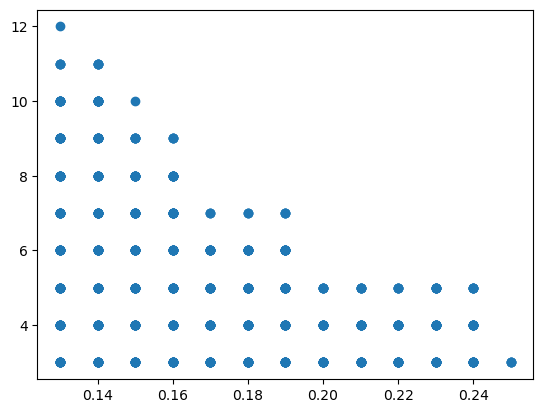

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('data5000Nodes/result_df_5000_nodes.csv')
filtert_data = data.query('size_of_cascade >90')
plt.scatter(filtert_data['p'],filtert_data['z'],)


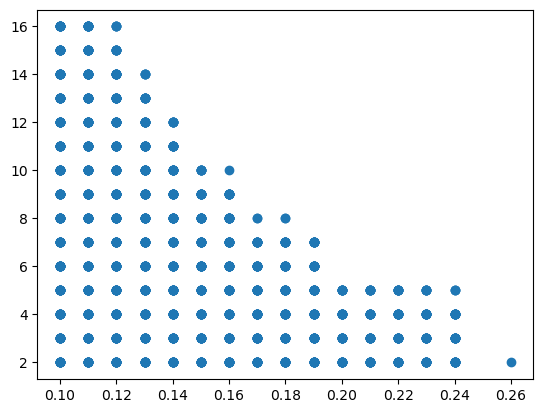

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('data5000Nodes/result_df_5000_22_12_.csv')
filtert_data = data.query('size_of_cascade >1000')
plt.scatter(filtert_data['p'],filtert_data['z'],)


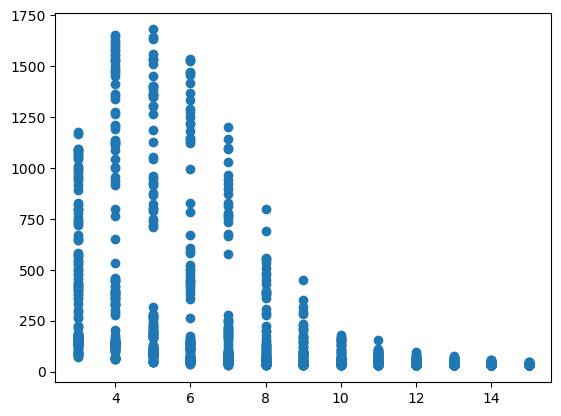

In [25]:
plt.scatter(data['z'],data['size_of_cascade'])

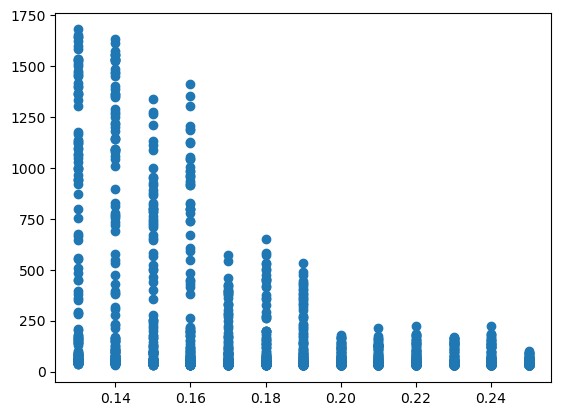

In [26]:
plt.scatter(data['p'],data['size_of_cascade'])

In [ ]:
n = network()
n.generate_a_network_version2(10000,5,0.10)